=== Delivery Route Optimization Demo ===

Unit1 (recurrence) minimal roundtrip cost (full visit): 18

Unit2 Greedy selected parcels (by value/weight): ['C1', 'C2']
Unit2 DP best (value, seq): 0 [] arrivals: {}

Unit3 Dijkstra distances from Warehouse: {'Warehouse': 0, 'C1': 4, 'C2': 8, 'C3': 6}
Unit3 Prim MST edges: [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)] total_weight: 12

Unit4 TSP brute optimal route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18
Unit4 TSP Held-Karp cost: 18
Profiling TSP times for n=3..7 (plot will show growth):
TSP prof: nodes=3 time=9e-06 cost_est=17
TSP prof: nodes=4 time=1.1e-05 cost_est=18
TSP prof: nodes=5 time=2.6e-05 cost_est=19
TSP prof: nodes=6 time=0.000123 cost_est=22
TSP prof: nodes=7 time=0.000792 cost_est=25


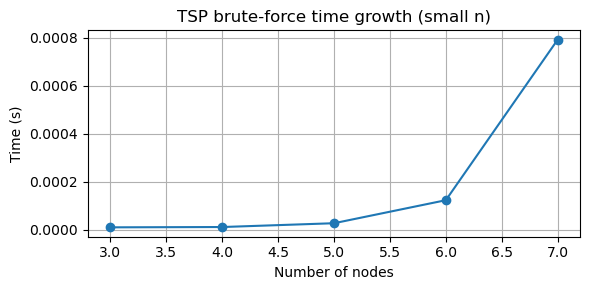


Combined best deliveries (value, seq): 0 []
Arrivals: {}
No deliveries to plot.


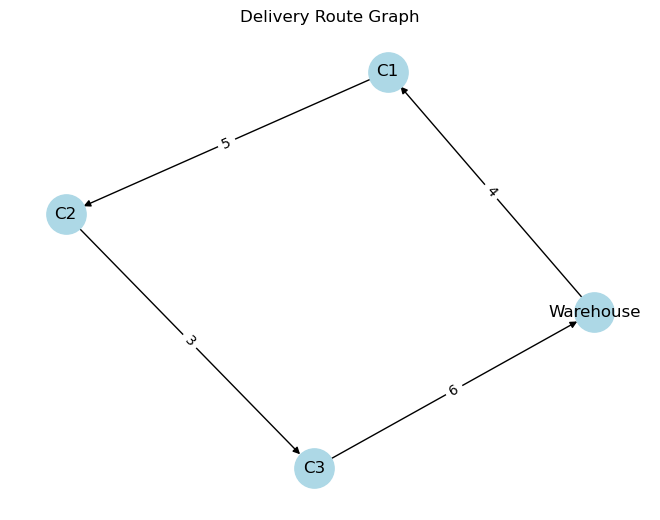

In [1]:
"""
Delivery Route Optimization for E-commerce
Units included:
 - Unit 1: Recurrence-based route cost estimation (simple recursive search)
 - Unit 2: Greedy (0/1 knapsack heuristic) + DP-based time-window delivery DFS+memo
 - Unit 3: Graph algorithms: Dijkstra (shortest path) + Prim (MST)
 - Unit 4: TSP: brute-force and Held-Karp DP (for small n)
 - Visualization: route graph (networkx) and Gantt-like bars + TSP timing plot
 - Profiling: time measurement for TSP for n = 3..7 (prints)
"""

import itertools
import heapq
import math
import time
from functools import lru_cache

# Optional plotting libs
import matplotlib.pyplot as plt
try:
    import networkx as nx
except Exception:
    nx = None  # networkx optional; plotting still works without it

# -----------------------------
# INPUT (sample)
# -----------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']  # index 0 = Warehouse
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30
vehicle_speed = 1.0  # units distance per hour (for converting distance->time if needed)

# Helper to get index by location name
loc_index = {loc: i for i, loc in enumerate(locations)}

# -----------------------------
# UNIT 1: Recurrence-based route cost estimation
# simple recursive search to compute minimal route cost visiting a subset/order
# Here: recursion that chooses next unvisited node minimizing incremental distance
# -----------------------------
def delivery_cost_recursive(current_index, unvisited):
    """
    Recurrence: minimal remaining cost starting from current_index visiting all unvisited and returning to warehouse.
    unvisited: tuple/list of indices (not including warehouse)
    """
    if not unvisited:
        return distance_matrix[current_index][0]  # return to warehouse
    min_cost = math.inf
    for i in range(len(unvisited)):
        nxt = unvisited[i]
        remaining = tuple(unvisited[:i] + unvisited[i+1:])
        cost = distance_matrix[current_index][nxt] + delivery_cost_recursive(nxt, remaining)
        if cost < min_cost:
            min_cost = cost
    return min_cost

def example_unit1():
    indices = tuple(range(1, len(locations)))
    cost = delivery_cost_recursive(0, indices)
    print("Unit1 (recurrence) minimal roundtrip cost (full visit):", cost)


# -----------------------------
# UNIT 2: Greedy (value/weight) + DP-like time-window delivery (DFS with memo)
# - Greedy selects high value/weight first until capacity
# - DP/DFS finds best subset respecting capacity and time windows by simple search
# -----------------------------
def greedy_knapsack(parcels_dict, capacity):
    items = []
    for loc, info in parcels_dict.items():
        ratio = info['value'] / info['weight']
        items.append((ratio, loc, info))
    items.sort(reverse=True)  # by value/weight descending
    selected = []
    cap = capacity
    for _, loc, info in items:
        if info['weight'] <= cap:
            selected.append(loc)
            cap -= info['weight']
    return selected

def feasible_sequence_timewise(sequence, start_time=9, speed=vehicle_speed):
    """
    Check if a sequence of deliveries (list of 'C#') can be satisfied within each parcel's time window.
    Assumes vehicle starts at Warehouse at start_time and visits sequence in order using distance_matrix.
    Returns (feasible_bool, arrival_times_dict)
    """
    time_now = start_time
    pos = 0  # warehouse index
    arrivals = {}
    for loc in sequence:
        nxt = loc_index[loc]
        travel_time = distance_matrix[pos][nxt] / speed
        time_now += travel_time
        window = parcels[loc]['time']
        # if arrive before earliest, wait until earliest
        if time_now < window[0]:
            time_now = window[0]
        # if arrival after latest, infeasible
        if time_now > window[1]:
            return False, {}
        arrivals[loc] = time_now
        pos = nxt
    return True, arrivals

# DP / DFS to maximize total value within capacity and time windows
def best_delivery_with_timewindows(parcels_dict, capacity, start_time=9):
    keys = list(parcels_dict.keys())
    n = len(keys)
    best = {'value': 0, 'sequence': [], 'arrivals': {}}

    @lru_cache(None)
    def dfs(used_mask, pos_index, cap_left, time_now):
        """
        used_mask: bitmask of delivered parcels
        pos_index: current position index (0..n) where 0 means Warehouse
        cap_left: remaining capacity (int)
        time_now: current time as float
        returns tuple (value, seq (tuple of locs), arrival_times_tuple (flattened pairs))
        """
        best_local = (0, (), ())
        # try to go to any undelivered parcel
        for i in range(n):
            bit = 1 << i
            if used_mask & bit:
                continue
            loc = keys[i]
            info = parcels_dict[loc]
            w = info['weight']
            if w > cap_left:
                continue
            # compute travel time from current pos
            cur_idx = 0 if pos_index == -1 else loc_index[keys[pos_index]]
            travel_time = distance_matrix[cur_idx][loc_index[loc]] / vehicle_speed
            arrival = time_now + travel_time
            # wait if arrive earlier than window start
            if arrival < info['time'][0]:
                arrival = info['time'][0]
            if arrival > info['time'][1]:
                continue  # cannot deliver this parcel next
            # recursive step
            val_next, seq_next, arr_next = dfs(used_mask | bit, i, cap_left - w, arrival)
            val_total = info['value'] + val_next
            seq_total = (loc,) + seq_next
            arr_total = (arrival,) + arr_next
            if val_total > best_local[0]:
                best_local = (val_total, seq_total, arr_total)
        return best_local

    val, seq, arr = dfs(0, -1, capacity, start_time)
    arrivals = {seq[i]: arr[i] for i in range(len(seq))}
    return {'value': val, 'sequence': list(seq), 'arrivals': arrivals}

def example_unit2():
    greedy_sel = greedy_knapsack(parcels, vehicle_capacity)
    print("Unit2 Greedy selected parcels (by value/weight):", greedy_sel)
    best = best_delivery_with_timewindows(parcels, vehicle_capacity, start_time=9)
    print("Unit2 DP best (value, seq):", best['value'], best['sequence'], "arrivals:", best['arrivals'])


# -----------------------------
# UNIT 3: Graph algorithms
# - Dijkstra for shortest path from Warehouse
# - Prim's MST for connecting nodes (using adjacency matrix)
# -----------------------------
def dijkstra(start_index=0):
    n = len(distance_matrix)
    dist = [math.inf]*n
    dist[start_index] = 0
    visited = [False]*n
    heap = [(0, start_index)]
    while heap:
        d,u = heapq.heappop(heap)
        if visited[u]:
            continue
        visited[u] = True
        for v in range(n):
            if u == v:
                continue
            nd = d + distance_matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(heap, (nd, v))
    return dist

def prim_mst():
    n = len(distance_matrix)
    in_mst = [False]*n
    key = [math.inf]*n
    parent = [-1]*n
    key[0] = 0
    for _ in range(n):
        u = min((key[i], i) for i in range(n) if not in_mst[i])[1]
        in_mst[u] = True
        for v in range(n):
            if not in_mst[v] and 0 < distance_matrix[u][v] < key[v]:
                key[v] = distance_matrix[u][v]
                parent[v] = u
    edges = []
    total = 0
    for v in range(1, n):
        edges.append((locations[parent[v]], locations[v], distance_matrix[parent[v]][v]))
        total += distance_matrix[parent[v]][v]
    return edges, total

def example_unit3():
    dist_from_warehouse = dijkstra(0)
    print("Unit3 Dijkstra distances from Warehouse:", {locations[i]: dist_from_warehouse[i] for i in range(len(locations))})
    edges, total = prim_mst()
    print("Unit3 Prim MST edges:", edges, "total_weight:", total)


# -----------------------------
# UNIT 4: TSP
# - Brute force for very small n
# - Held-Karp DP (bitmask) for slightly larger small n (n <= 12 workable)
# Also: timing profiling for sizes 3..7
# -----------------------------
def tsp_brute_force(locations_local, matrix_local):
    n = len(locations_local)
    indices = list(range(1, n))
    min_cost = math.inf
    best_route = None
    for perm in itertools.permutations(indices):
        cost = matrix_local[0][perm[0]]
        for i in range(len(perm)-1):
            cost += matrix_local[perm[i]][perm[i+1]]
        cost += matrix_local[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best_route = (0,) + perm + (0,)
    route_names = [locations_local[i] for i in best_route]
    return route_names, min_cost

def tsp_held_karp(matrix_local):
    n = len(matrix_local)
    # DP[mask][i] = min cost to reach subset mask and end at i (i != 0), mask includes 0 implicitly
    N = 1 << n
    dp = [[math.inf]*n for _ in range(N)]
    dp[1][0] = 0  # starting at 0 with mask 1
    for mask in range(1, N):
        for u in range(n):
            if not (mask & (1 << u)):
                continue
            if dp[mask][u] == math.inf:
                continue
            for v in range(n):
                if mask & (1 << v):
                    continue
                new_mask = mask | (1 << v)
                new_cost = dp[mask][u] + matrix_local[u][v]
                if new_cost < dp[new_mask][v]:
                    dp[new_mask][v] = new_cost
    full_mask = (1 << n) - 1
    min_cost = math.inf
    last = -1
    for u in range(1, n):
        cost = dp[full_mask][u] + matrix_local[u][0]
        if cost < min_cost:
            min_cost = cost
            last = u
    return min_cost

def profile_tsp(max_nodes=7):
    times = []
    sizes = []
    for k in range(3, max_nodes+1):
        # Build a small symmetric matrix from top-left of distance_matrix or generate
        # If k > provided, create synthetic matrix (triangle inequality not guaranteed but ok)
        nmat = [[0]*k for _ in range(k)]
        for i in range(k):
            for j in range(k):
                if i == j:
                    nmat[i][j] = 0
                else:
                    # use portion of base matrix if available else simple function
                    if i < len(distance_matrix) and j < len(distance_matrix):
                        nmat[i][j] = distance_matrix[i][j]
                    else:
                        nmat[i][j] = abs(i-j)+1
        locations_small = [f'P{i}' for i in range(k)]
        t0 = time.perf_counter()
        if k <= 9:
            _route, cost = tsp_brute_force(locations_small, nmat)
        else:
            cost = tsp_held_karp(nmat)
        t1 = time.perf_counter()
        times.append(t1-t0)
        sizes.append(k)
        print(f"TSP prof: nodes={k} time={round(t1-t0,6)} cost_est={cost}")
    # plot
    plt.figure(figsize=(6,3))
    plt.plot(sizes, times, marker='o')
    plt.xlabel("Number of nodes")
    plt.ylabel("Time (s)")
    plt.title("TSP brute-force time growth (small n)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def example_unit4():
    route, cost = tsp_brute_force(locations, distance_matrix)
    print("Unit4 TSP brute optimal route:", route, "cost:", cost)
    hk_cost = tsp_held_karp(distance_matrix)
    print("Unit4 TSP Held-Karp cost:", hk_cost)
    print("Profiling TSP times for n=3..7 (plot will show growth):")
    profile_tsp(7)


# -----------------------------
# Visualization helpers
# - plot route network (networkx if available) and Gantt-like schedule
# -----------------------------
def plot_route_network(best_route):
    if nx is None:
        print("networkx not available: skipping network plot.")
        return
    G = nx.DiGraph()
    for i, u in enumerate(locations):
        G.add_node(u)
    # add edges of route in order
    for i in range(len(best_route)-1):
        a = best_route[i]
        b = best_route[i+1]
        G.add_edge(a, b, weight=distance_matrix[loc_index[a]][loc_index[b]])
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Delivery Route Graph")
    plt.show()

def plot_delivery_gantt(sequence, arrivals):
    # simple horizontal bars by arrival times and service duration (assume 0.5h service)
    if not sequence:
        print("No deliveries to plot.")
        return
    fig, ax = plt.subplots(figsize=(7, 2+len(sequence)*0.5))
    y = range(len(sequence))
    for i, loc in enumerate(sequence):
        start = arrivals[loc] - 0.25  # estimate start slightly before recorded arrival
        duration = 0.5
        ax.barh(i, duration, left=start, height=0.4)
        ax.text(start + 0.05, i, loc + f" ({arrivals[loc]:.2f})")
    ax.set_yticks(y)
    ax.set_yticklabels(sequence)
    ax.set_xlabel("Time (hours)")
    ax.set_title("Delivery sequence (Gantt-like)")
    plt.show()

# -----------------------------
# MAIN: run examples for all units
# -----------------------------
if __name__ == "__main__":
    print("=== Delivery Route Optimization Demo ===\n")
    # Unit1
    example_unit1()
    print()

    # Unit2
    example_unit2()
    print()

    # Unit3
    example_unit3()
    print()

    # Unit4
    example_unit4()
    print()

    # Combine: get best DP solution and plot its gantt+network
    best = best_delivery_with_timewindows(parcels, vehicle_capacity, start_time=9)
    print("Combined best deliveries (value, seq):", best['value'], best['sequence'])
    print("Arrivals:", best['arrivals'])
    plot_delivery_gantt(best['sequence'], best['arrivals'])
    # If we solved a TSP route earlier, plot using networkx (tentative)
    route, cost = tsp_brute_force(locations, distance_matrix)
    plot_route_network(route)
